## LLM Inference Workshop

This notebook explores how to run inference with Large Language Models (LLMs) efficiently, demonstrating the progression from full precision to quantized models.

In [ ]:
#!pip install -q transformers torch accelerate bitsandbytes psutil pandas matplotlib

In [2]:
!nvidia-smi

Sat May  3 18:50:39 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 NVL                On  | 00000000:17:00.0 Off |                    0 |
| N/A   33C    P0              61W / 400W |      0MiB / 95830MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Loading Models with Different Precision

Let's explore different precision options for LLM inference, starting with higher precision (fp16/bf16) and then moving to quantized models (8-bit, 4-bit).

In [3]:
import textwrap
from IPython.display import display, clear_output
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, logging as hf_logging
import torch
import time
import os
import psutil
import pandas as pd
import matplotlib.pyplot as plt


hf_logging.set_verbosity_error()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.get_device_properties(device))

/software/python-anaconda-2022.05-el8-x86_64/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


_CudaDeviceProperties(name='NVIDIA H100 NVL', major=9, minor=0, total_memory=95248MB, multi_processor_count=132, uuid=05c8d75e-a104-1bf7-9b12-317666e3ec95, L2_cache_size=60MB)


`print_memory_usage()` provides utilities for benchmarking Large Language Model (LLM) inference performance:

- Checks if CUDA (GPU) is available
- If available, returns the current GPU memory usage in megabytes (MB)
- Useful for monitoring memory consumption during model inference

In [ ]:
def print_memory_usage():
    """Return current GPU memory usage in MB (allocated), or None if no GPU is available."""
    if torch.cuda.is_available():
        allocated_bytes = torch.cuda.memory_allocated()
        return allocated_bytes / (1024 * 1024)

`inference_benchmark()` measures LLM inference speed:

- Setup: Tokenizes the input prompt and moves it to the device (CPU/GPU)
- Warmup: Performs an initial generation run to initialize the model (not included in timing)
- Benchmarking: Runs model inference multiple times (num_runs), measuring execution time
- Results: Returns a dictionary with:
- avg_time: Average time per inference run in seconds
- tokens_per_second: Throughput metric showing generation speed


In [ ]:
def inference_benchmark(model, tokenizer, prompt, num_runs=3, max_new_tokens=256):
    """Benchmark inference speed"""
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    # Warmup
    _ = model.generate(inputs["input_ids"], max_new_tokens=100)
    
    # Benchmark
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        _ = model.generate(
            inputs["input_ids"],
            max_new_tokens=max_new_tokens
        )
        times.append(time.time() - start_time)
    
    return {
        "avg_time": sum(times) / len(times),
        "tokens_per_second": max_new_tokens / (sum(times) / len(times))
    }


In [6]:
# Choose a model 
#model_id = "/project/rcc/shared/ai-workshops/Qwen2.5-7B-Instruct-1M"
model_id = "/project/rcc/shared/ai-workshops/Mistral-Small-24B-Instruct-2501"
tokenizer = AutoTokenizer.from_pretrained(model_id)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

### FP16 Precision (Half Precision)

Let's first load the model in FP16 precision, which is a good balance between accuracy and memory efficiency.

In [ ]:
print("Loading model with FP16 precision...")
base_memory = print_memory_usage()

# Load model with FP16 precision
model_fp16 = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
)
# move model to GPU
model_fp16.to(device)

fp16_memory = print_memory_usage() - base_memory
print(f"Memory footprint: {fp16_memory:.2f} MB")

Loading model with FP16 precision...


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.49s/it]


Memory footprint: 44960.81 MB


Before running inference, we need to set up prompts.

### System Prompt
The system prompt defines the behavior, constraints, and personality of the AI model. It establishes:

- **Role definition**: Sets the AI's identity ("You are a helpful assistant")
- **Output formatting**: Specifies how responses should be structured ("One plain paragraph")
- **Response style**: Defines tone and approach ("concise and clear")
- **Constraints**: Sets boundaries on what the model should avoid ("no lists, no headings, no filler")

### User Prompt
The user prompt contains the actual query or task for the model to address. In this case, it requests an explanation about transformers with a specific focus on self-attention mechanisms.

In [ ]:
system_prompt = """
You are a helpful assistant. You will be given a task and you should respond with a solution.
You should be concise and clear. You should not include any unnecessary information or details.
One plain paragraph—no lists, no headings, no filler.
"""

prompt = "Give me a short introduction to large language model inference."


messages = [
    {"role": "system",    "content": system_prompt},
    {"role": "user",      "content": prompt},
]


To run some inference with the FP16 model:

In [9]:
input_ids = tokenizer.apply_chat_template(
              messages,
              add_generation_prompt=True,   # inserts the assistant marker
              return_tensors="pt").to(model_fp16.device)

gen_ids = model_fp16.generate(input_ids, max_new_tokens=256)
new_tokens = gen_ids[:, input_ids.shape[-1]:]        # <-- slice away the prompt
response   = tokenizer.decode(new_tokens[0], skip_special_tokens=True)

print("Sample output from FP16 model:")
print(textwrap.fill(response, 100))


Sample output from FP16 model:
Large language model inference involves using a pre-trained language model to generate text,
translate languages, answer questions, or perform other natural language processing tasks. During
inference, the model takes an input sequence of text and predicts the most likely next words or
phrases based on patterns it learned during training. This process leverages the model's
understanding of language structure, semantics, and context to produce coherent and contextually
relevant outputs.


In [10]:
# Storage for benchmark results
results = []

fp16_benchmark = inference_benchmark(model_fp16, tokenizer, prompt)
results.append({
    "Precision": "FP16",
    "Memory (MB)": fp16_memory,
    "Avg Generation Time (s)": fp16_benchmark["avg_time"],
    "Tokens/Second": fp16_benchmark["tokens_per_second"]
})


### BF16 Precision (Brain Floating Point)

BF16 has the same number of bits as FP16 but a different distribution of precision, often better for training numerical stability.

In [ ]:
# Free up memory
del model_fp16
torch.cuda.empty_cache()
print_memory_usage()

# Load model with BF16 precision
print("Loading model with BF16 precision...")
base_memory = print_memory_usage()

model_bf16 = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
)

model_bf16.to(device)

bf16_memory = print_memory_usage() - base_memory
print(f"Memory footprint: {bf16_memory:.2f} MB")

Loading model with BF16 precision...


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.73it/s]


Memory footprint: 44960.81 MB


In [12]:
# Test BF16 model inference
bf16_benchmark = inference_benchmark(model_bf16, tokenizer, prompt)
results.append({
    "Precision": "BF16",
    "Memory (MB)": bf16_memory,
    "Avg Generation Time (s)": bf16_benchmark["avg_time"],
    "Tokens/Second": bf16_benchmark["tokens_per_second"]
})

# Free up memory
del model_bf16
torch.cuda.empty_cache()

### 8-bit Quantization

Now let's try 8-bit quantization, which significantly reduces memory usage with minimal impact on quality.

In [13]:
print("Loading model with 8-bit quantization...")
base_memory = print_memory_usage()

model_8bit = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    load_in_8bit=True
)

int8_memory = print_memory_usage() - base_memory
print(f"Memory footprint: {int8_memory:.2f} MB")

Loading model with 8-bit quantization...


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.18s/it]

Memory footprint: 23773.31 MB


In [14]:
# Test 8-bit model inference
int8_benchmark = inference_benchmark(model_8bit, tokenizer, prompt)
results.append({
    "Precision": "INT8",
    "Memory (MB)": int8_memory,
    "Avg Generation Time (s)": int8_benchmark["avg_time"],
    "Tokens/Second": int8_benchmark["tokens_per_second"]
})

# Free up memory
del model_8bit
torch.cuda.empty_cache()

### 4-bit Quantization

Finally, let's try 4-bit quantization, which offers the maximum memory savings but may have more quality impact.

In [15]:
print("Loading model with 4-bit quantization...")
base_memory = print_memory_usage()

# Configure 4-bit quantization options
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",  # normalized float 4 format
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

model_4bit = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
)

model_4bit.to(device)

int4_memory = print_memory_usage() - base_memory
print(f"Memory footprint: {int4_memory:.2f} MB")

Loading model with 4-bit quantization...


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.28s/it]

Memory footprint: 13497.53 MB


In [16]:
# Test 4-bit model inference
int4_benchmark = inference_benchmark(model_4bit, tokenizer, prompt)
results.append({
    "Precision": "INT4",
    "Memory (MB)": int4_memory,
    "Avg Generation Time (s)": int4_benchmark["avg_time"],
    "Tokens/Second": int4_benchmark["tokens_per_second"]
})


input_ids = tokenizer.apply_chat_template(
              messages,
              add_generation_prompt=True,   # inserts the assistant marker
              return_tensors="pt").to(model_4bit.device)

gen_ids = model_4bit.generate(input_ids, max_new_tokens=256)
new_tokens = gen_ids[:, input_ids.shape[-1]:]        # <-- slice away the prompt
response   = tokenizer.decode(new_tokens[0], skip_special_tokens=True)

print("Sample output from 4-Bit model:")
print(textwrap.fill(response, 100))


Sample output from 4-Bit model:
Large language model inference involves using a pre-trained language model to generate text,
translate languages, answer questions, or perform other natural language processing tasks. During
inference, the model takes input text and processes it through its layers to produce output text.
This process leverages the model's learned patterns and structures from its training data to
generate coherent and contextually relevant responses. The quality of the output depends on the
model's architecture, the size of its training data, and the specific techniques used during
training and inference.


## FlashAttention

In [17]:
print("Loading model with Flash Attention in FP16 precision...")
base_memory = print_memory_usage()

# Load model with FP16 precision

model_flashattention = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    attn_implementation="flash_attention_2" if torch.cuda.is_available() else "eager",
    device_map="auto" 
)

fp16fa_memory = print_memory_usage() - base_memory
print(f"Memory footprint: {fp16_memory:.2f} MB")

Loading model with Flash Attention in FP16 precision...


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.18s/it]

Memory footprint: 44960.81 MB


In [18]:
# Test FP16 flash attention model inference
fp16fa_benchmark = inference_benchmark(model_flashattention, tokenizer, prompt)
results.append({
    "Precision": "FP16-FA",
    "Memory (MB)": fp16fa_memory,
    "Avg Generation Time (s)": fp16fa_benchmark["avg_time"],
    "Tokens/Second": fp16fa_benchmark["tokens_per_second"]
})



input_ids = tokenizer.apply_chat_template(
              messages,
              add_generation_prompt=True,   # inserts the assistant marker
              return_tensors="pt").to(model_flashattention.device)

gen_ids = model_flashattention.generate(input_ids, max_new_tokens=256)
new_tokens = gen_ids[:, input_ids.shape[-1]:]        # <-- slice away the prompt
response   = tokenizer.decode(new_tokens[0], skip_special_tokens=True)

print("Sample output from 16-bit flash attention quantized model:")
print(textwrap.fill(response, 100))


Sample output from 16-bit flash attention quantized model:
Large language model inference involves using a pre-trained language model to generate text,
translate languages, answer questions, or perform other natural language processing tasks. During
inference, the model takes an input sequence of text and predicts the most likely next words or
phrases based on patterns it learned during training. This process leverages the model's
understanding of language structure, semantics, and context to produce coherent and contextually
relevant outputs.


## Comparing Results

Let's visualize and compare the results from different precision formats:

In [21]:
results_df = pd.DataFrame(results)
display(results_df)

,Precision,Memory (MB),Avg Generation Time (s),Tokens/Second
0,FP16,44960.810547,14.684128,17.433789
1,BF16,44960.810547,13.532828,18.916962
2,INT8,23773.310547,38.672399,6.619708
3,INT4,13497.530273,20.847846,12.279446
4,FP16-FA,44960.810547,14.978494,17.091171


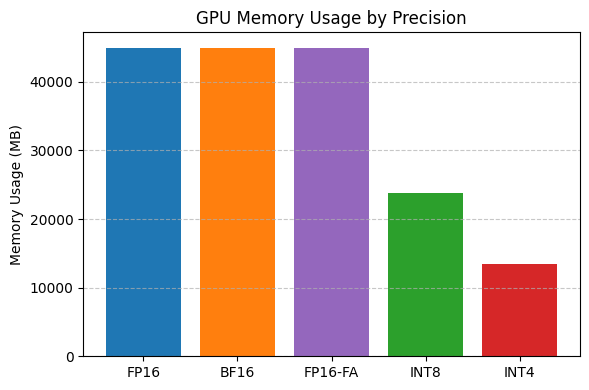

In [22]:
unique_precisions = results_df["Precision"].unique()
color_map = {prec: f"C{i}" for i, prec in enumerate(unique_precisions)}

# ------------------------------------------------------------------
# MEMORY-USAGE PLOT (largest → smallest) ------------------------
# ------------------------------------------------------------------
mem_sorted = results_df.sort_values("Memory (MB)", ascending=False)
colors_mem = [color_map[p] for p in mem_sorted["Precision"]]

plt.figure(figsize=(6, 4))
plt.bar(mem_sorted["Precision"],
        mem_sorted["Memory (MB)"],
        color=colors_mem)
plt.title("GPU Memory Usage by Precision")
plt.ylabel("Memory Usage (MB)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

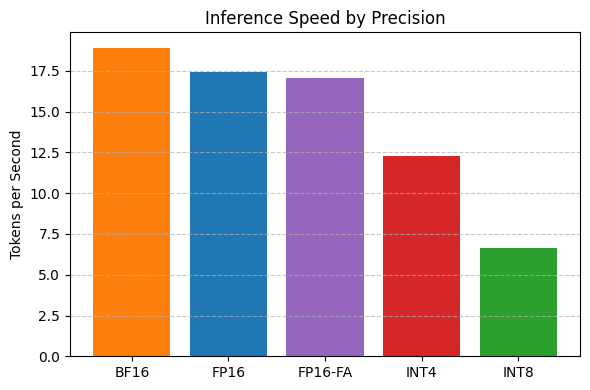

In [23]:
# ------------------------------------------------------------------
# SPEED PLOT (largest → smallest) -------------------------------
# ------------------------------------------------------------------
speed_sorted = results_df.sort_values("Tokens/Second", ascending=False)
colors_speed = [color_map[p] for p in speed_sorted["Precision"]]

plt.figure(figsize=(6, 4))
plt.bar(speed_sorted["Precision"],
        speed_sorted["Tokens/Second"],
        color=colors_speed)
plt.title("Inference Speed by Precision")
plt.ylabel("Tokens per Second")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### top_k, top_p, tempurature

In [24]:
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": "Give me a short introduction to large language model inference."}
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,      # inserts the assistant-start marker
    return_tensors="pt"
).to(model_4bit.device)


gen_ids = model_4bit.generate(
    input_ids,
    max_new_tokens=256,
    do_sample=False                  # greedy search
)

# --- drop the prompt tokens and decode only the reply ---
assistant_tokens = gen_ids[:, input_ids.shape[-1]:]
greedy_response  = tokenizer.decode(assistant_tokens[0], skip_special_tokens=True)

print("=== Greedy decoding (no sampling) ===")
print(textwrap.fill(greedy_response, 100))



/software/python-anaconda-2022.05-el8-x86_64/envs/pytorch/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.15` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


=== Greedy decoding (no sampling) ===
Large language model inference involves using a pre-trained language model to generate text,
translate languages, answer questions, or perform other natural language processing tasks. During
inference, the model takes input text, processes it through its layers to understand the context and
meaning, and then generates a relevant output based on the learned patterns from its training data.
This process leverages the model's ability to predict the next word(s) in a sequence, making it
highly versatile for various applications.


In [26]:
# --- temperature sampling ----------------------------------------------------
temp_ids = model_4bit.generate(
    input_ids,
    max_new_tokens=256,
    do_sample=True,                  # enables stochastic sampling
    temperature=1.5                  # higher = more diverse generations
)

# --- strip the prompt and decode only the reply ------------------------------
assistant_ids = temp_ids[:, input_ids.shape[-1]:]
temp_response = tokenizer.decode(assistant_ids[0], skip_special_tokens=True)

print("=== Temperature Sampling (T = 1.5) ===")
print(textwrap.fill(temp_response, 100))



=== Temperature Sampling (T = 1.5) ===
Large language model (LLM) inference involves using a trained LLM to generate responses to user
prompts, or answer questions. The model learns a probability distribution from its  preprocessing
during the model optimization phase, as LLM takes in as input, a piece of a sequential information
such text and predicts the upcoming token based on that. The model is usually trained extensively
based a a very large of corpus (million parameters  and billions of text from the internet ). By
computing this probabilities on given prompts at each iteration when the token is produced, this the
model makes a prediction so that the output that emerges matches the most probable next input
expected (to meet user desire); however the resulting output may have a little room for non
deterministic output which allows flexibility in results which sometimes have creativity at the
heart or some errors at a larger token level (if poorly trained). But its always better tr

In [27]:
# --- temperature sampling ----------------------------------------------------
temp_ids = model_4bit.generate(
    input_ids,
    max_new_tokens=256,
    do_sample=True,                  # enables stochastic sampling
    temperature=5.5                  # higher = more diverse generations
)

# --- strip the prompt and decode only the reply ------------------------------
assistant_ids = temp_ids[:, input_ids.shape[-1]:]
temp_response = tokenizer.decode(assistant_ids[0], skip_special_tokens=True)

print("=== Temperature Sampling (T = 5.5) ===")
print(textwrap.fill(temp_response, 100))


=== Temperature Sampling (T = 5.5) ===
Given enough large input, including human words it previously saw; Language can get data that can
find output  which might get you answer; for your answer the first part will learn large parts;
model was given  in 7 large step from this kind, one answer you would expect more inference as
answer that gets given next sentence is model can. Also I’m giving as the solution an example on
step two on the one word with which get data. Can your get answers step with an answer can say as
you know a word the second I write the get an accurate part the input large language on each next
question you know to word input what will your be the solution with part of first two are a number
the answer should say accurate output of number with part to model. It takes your response or say an
other first for number of which kind  you number that it knows which of can accurate which the the
step you accurate in answer . Also if input language get input get which number 

In [29]:
topk_outputs = model_4bit.generate(
    input_ids, 
    max_new_tokens=256, 
    do_sample=True,
    temperature=0.7, 
    top_k=50  # Only sample from top 50 tokens
)

assistant_ids = topk_outputs[:, input_ids.shape[-1]:]    
topk_response = tokenizer.decode(assistant_ids[0], skip_special_tokens=True)  
print("=== Top-k Sampling (k=50, T=0.7) ===")
print(textwrap.fill(topk_response, 100))
print()

=== Top-k Sampling (k=50, T=0.7) ===
Large language model inference involves using a pre-trained language model to generate text,
translate languages, answer questions, or perform other natural language processing tasks. During
inference, input text is processed through the model's layers to produce a probability distribution
over possible next tokens. The token with the highest probability, or a sample from the
distribution, is selected as the output. This process can be repeated to generate longer sequences
of text, with techniques like beam search or top-k sampling used to manage the output diversity and
coherence.



In [30]:
topp_outputs = model_4bit.generate(
    input_ids,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.7,
    top_p=0.9   # Keep the top 90% probability mass
)

assistant_ids = topp_outputs[:, input_ids.shape[-1]:]    
topp_response = tokenizer.decode(assistant_ids[0], skip_special_tokens=True)  

print("=== Top-p Sampling (p=0.9, T=0.7) ===")
print(textwrap.fill(topp_response, 100))
print()


=== Top-p Sampling (p=0.9, T=0.7) ===
Large language model inference involves using a pre-trained model to generate text, translate
languages, answer questions, or perform other tasks. The model processes input text and predicts the
most likely next words or phrases based on patterns it learned during training. This is done using a
process called autoregressive generation, where the model generates one token at a time, using the
previously generated tokens as context. The model's performance depends on its architecture,
training data, and the specific inference technique used.



In [31]:
combo_outputs = model_4bit.generate(
    input_ids,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.8,
    top_k=50,
    top_p=0.9
)

assistant_ids = combo_outputs[:, input_ids.shape[-1]:]    
combo_response = tokenizer.decode(assistant_ids[0], skip_special_tokens=True)  
print("=== Combined Sampling (top_k=50, top_p=0.9, T=0.8) ===")
print(textwrap.fill(combo_response, 100))
print()


=== Combined Sampling (top_k=50, top_p=0.9, T=0.8) ===
Large language model inference involves using a pre-trained model to generate text predictions based
on given input. The model has been trained on a vast amount of data, allowing it to understand and
produce human-like text. During inference, the model processes input data, predicts the likelihood
of subsequent words or tokens, and generates text by selecting the most probable options. This
process can be used for various natural language processing tasks, such as text completion,
translation, summarization, and question-answering.



## Advanced Inference Techniques

Now that we've selected 4-bit quantization for its efficiency, let's explore more advanced inference techniques.

### Batch Processing for Throughput

Processing multiple inputs at once can be more efficient:

In [ ]:
# Create a batch of prompts
prompts = [
    "What is machine learning?",
    "Explain neural networks",
    "How do transformers work?",
    "Define reinforcement learning",
    "What is transfer learning?"
]

# Process individually
start_time = time.time()
individual_outputs = []
for prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(model_4bit.device)
    outputs = model_4bit.generate(inputs["input_ids"], 
                                  max_new_tokens=256)
    individual_outputs.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
    
individual_time = time.time() - start_time
print(f"Individual processing time: {individual_time:.2f}s")

# Process as a batch
start_time = time.time()
batch_inputs = tokenizer(prompts, padding=True, return_tensors="pt").to(model_4bit.device)
batch_outputs = model_4bit.generate(batch_inputs["input_ids"], 
                                    max_new_tokens=256)

batch_decoded = [tokenizer.decode(output, skip_special_tokens=True) for output in batch_outputs]
batch_time = time.time() - start_time
print(f"Batch processing time: {batch_time:.2f}s")
print(f"Speed improvement: {individual_time/batch_time:.2f}x")

Individual processing time: 124.42s
Batch processing time: 102.71s
Speed improvement: 1.21x


### Using KV Caching for Faster Generation

In [ ]:
# ----- build one chat exchange ------------------------------------------------
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": "The benefits of artificial intelligence in healthcare include:"}
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model_4bit.device)

# ----- generation without KV-cache -------------------------------------------
start_time = time.time()
no_cache_ids = model_4bit.generate(
    input_ids,
    max_new_tokens=512,
    use_cache=False            # turn OFF cache
)
t_no_cache = time.time() - start_time
print(f"Standard generation time (no-cache): {t_no_cache:.2f}s")

# strip prompt and decode
reply_no_cache = tokenizer.decode(no_cache_ids[0][input_ids.shape[-1]:],
                                  skip_special_tokens=True)

# ----- generation with KV-cache ----------------------------------------------
start_time = time.time()
cache_ids = model_4bit.generate(
    input_ids,
    max_new_tokens=512,
    use_cache=True             # turn ON cache
)
t_cache = time.time() - start_time
print(f"KV cache generation time: {t_cache:.2f}s")
print(f"Speed improvement: {t_no_cache / t_cache:.2f}x")



Standard generation time (no-cache): 38.82s
KV cache generation time: 4.82s
Speed improvement: 8.06x


### Streaming Generation

For better user experience, we can stream the model output:

In [ ]:
# ---- build system + user messages -------------------------------------------
system_prompt = """You are a helpful assistant. Reply concisely in one paragraph."""
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user",   "content": "Write a short introduction about machine learning:"}
]

# ---- format with the tokenizer’s chat template ------------------------------
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,          # inserts the assistant-start token
    return_tensors="pt"
).to(model_fp16.device)

prompt_len   = input_ids.shape[-1]       # remember where the reply begins
generated_ids = input_ids.clone()        # will grow token-by-token
past_key_values = None
response = ""                            # what we display

# ---- streamed generation loop -----------------------------------------------
for _ in range(200):
    clear_output(wait=True)
    print(textwrap.fill(response, 100), end="")

    with torch.no_grad():
        outputs = model_4bit(
            input_ids = generated_ids[:, -1:] if past_key_values is not None else generated_ids,
            past_key_values = past_key_values,
            use_cache = True              # keep / extend the KV cache
        )

    past_key_values = outputs.past_key_values

    # temperature sampling (T = 0.7)
    logits = outputs.logits[:, -1, :] / 0.7
    probs  = torch.softmax(logits, dim=-1)
    next_token_id = torch.multinomial(probs, num_samples=1)

    generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)

    # decode only the new assistant token
    next_tok = tokenizer.decode(next_token_id[0], skip_special_tokens=True)
    response += next_tok

    # stop if EOS
    if next_token_id.item() == tokenizer.eos_token_id:
        break

    time.sleep(0.1)                       # slow down for the demo


print(textwrap.fill(response, 100))


Machine learning is a subset of artificial intelligence that involves training algorithms to learn
from data, identify patterns, and make decisions with minimal human intervention. It uses
statistical techniques to enable computers to improve their performance on a task over time, without
being explicitly programmed for that task. Machine learning is widely applied in various fields such
as image and speech recognition, natural language processing, and predictive analytics, driving
advancements in technology and data-driven decision-making.Machine learning is a subset of artificial intelligence that involves training algorithms to learn
from data, identify patterns, and make decisions with minimal human intervention. It uses
statistical techniques to enable computers to improve their performance on a task over time, without
being explicitly programmed for that task. Machine learning is widely applied in various fields such
as image and speech recognition, natural language processing, a

## Conclusion and Further Resources

In this notebook, we've explored various techniques for efficient LLM inference:

1. Different precision formats (FP16, BF16, INT8, INT4) with their memory and speed tradeoffs
2. Batch processing for increased throughput
3. KV caching for faster token generation
4. Streaming generation for better user experience
5. Speculative decoding to speed up inference

For further optimization, consider exploring:

- Specialized inference libraries like vLLM, DeepSpeed or TensorRT-LLM
- Mixture of Experts (MoE) models like Mixtral
- Model distillation to create smaller, faster models
- Prompt engineering for token efficiency
- Hardware-specific optimizations (CUDA graphs, FlashAttention, etc.)

Key references:
- [Hugging Face Efficient Inference Guide](https://huggingface.co/docs/transformers/main/en/perf_infer_gpu_one)
- [vLLM Documentation](https://docs.vllm.ai/)
- [Speculative Decoding Paper](https://arxiv.org/abs/2302.01318)
- [FlashAttention Paper](https://arxiv.org/abs/2205.14135)